In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.impute import SimpleImputer # for missing data

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
x_test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
y_test = pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv')

## Data Preparation For Data Understanding

In [3]:
test = pd.merge(x_test, y_test, on='Id')
all_data= pd.concat([train, test], axis=0)

In [4]:
# bütün kolonları ve satıları görme
pd.set_option('display.max_columns', ((all_data.shape[0]) + 1)) 

In [5]:
all_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,167081.220949
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,164788.778231
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,219222.423400
1457,2918,85,RL

In [6]:
len(all_data.columns)

81

### Filling and Deleting NaN Columns

In [7]:
# bu sütunlardaki veriler o kadar da eksik değil o yüzden nan olan değerlere en sık tekrar eden 
# değerleri atadık
nan_columns = ['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'MasVnrType', 'MasVnrArea', 'BsmtCond', 'TotalBsmtSF', 
               'Electrical', 'FullBath', 'HalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea', 'GarageQual', 
               'GarageCond', 'OpenPorchSF', 'EnclosedPorch', 'PoolArea', 'MiscFeature', 
               'SaleType', 'SaleCondition']

imputer_num = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
all_data[nan_columns] = imputer_num.fit_transform(all_data[nan_columns]) 

In [8]:
# giderilemeyecek kadar az veriye sahip olan kolonları sildik
all_data.dropna(axis=1, how="any", inplace=True)

<AxesSubplot:>

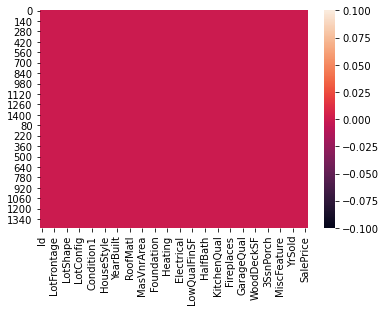

In [9]:
sns.heatmap(all_data.isnull())

In [10]:
len(all_data.columns)

64

In [11]:
# sayısal kategorik kolonları bulmak için 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_cols = all_data.select_dtypes(include=numerics).columns
type(numeric_cols)

pandas.core.indexes.base.Index

In [12]:
len(all_data.columns)

64

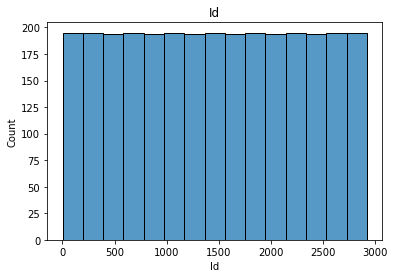

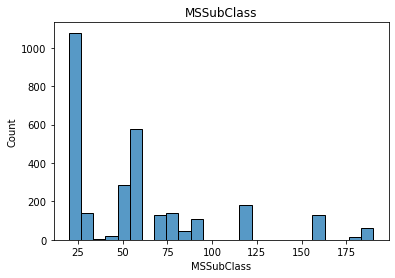

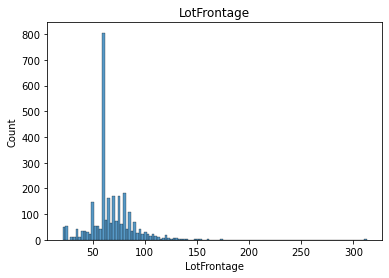

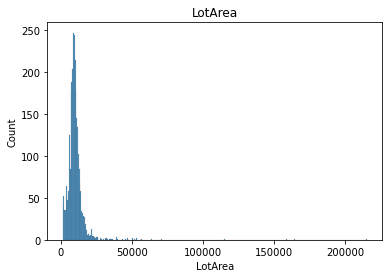

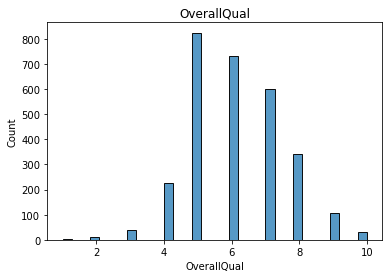

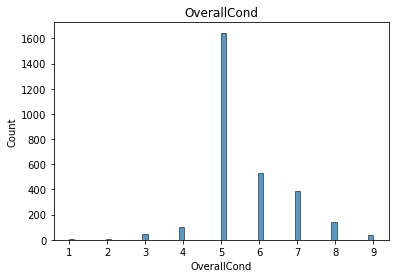

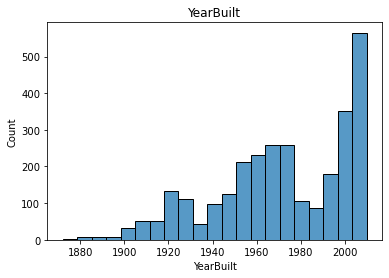

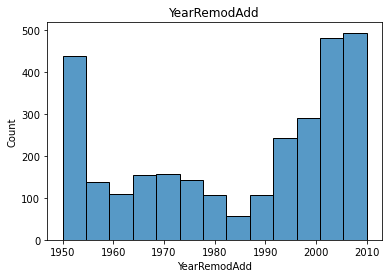

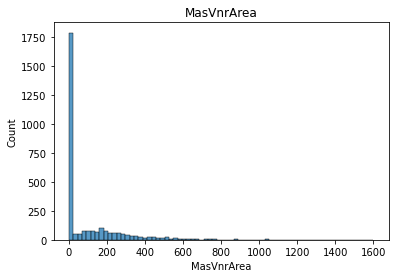

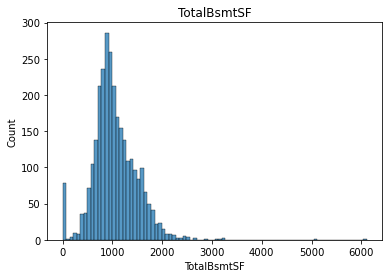

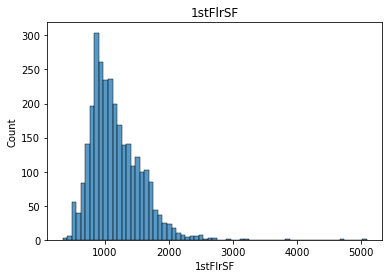

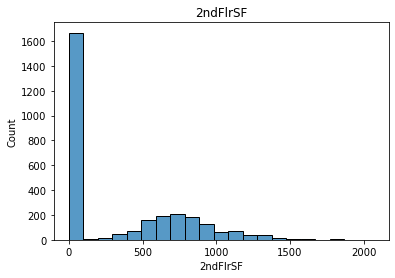

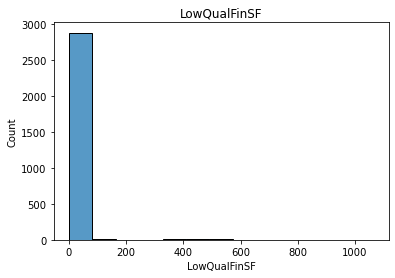

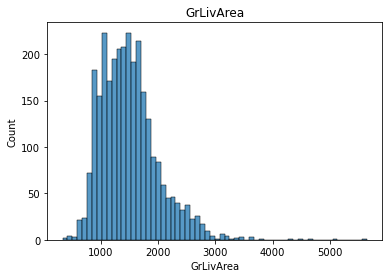

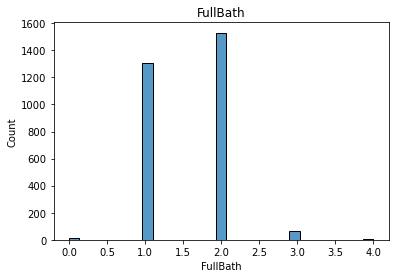

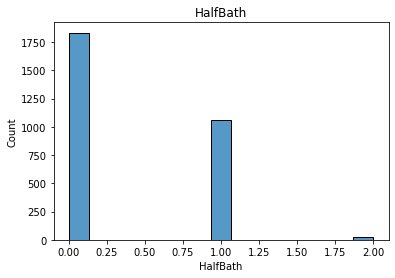

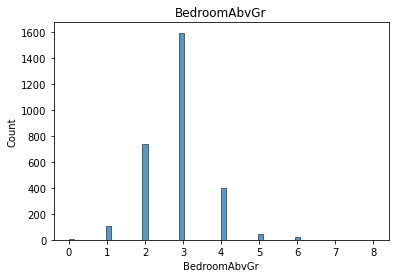

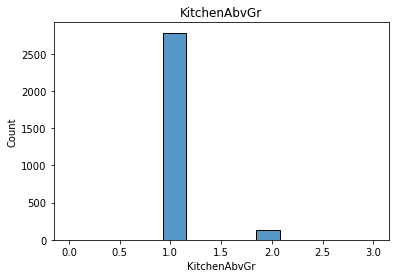

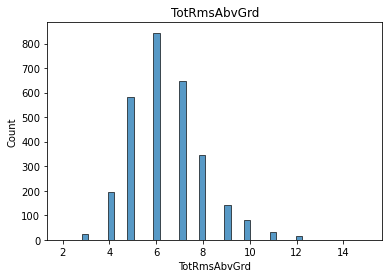

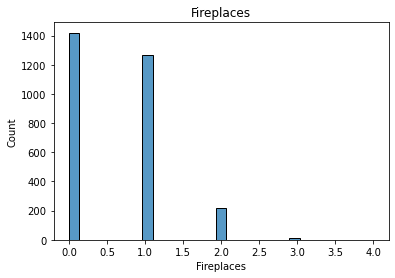

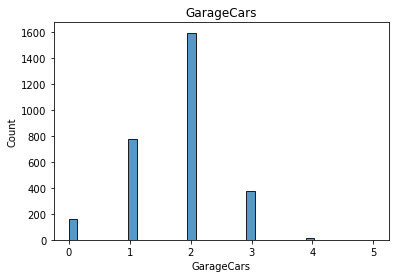

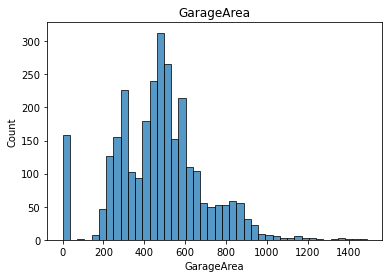

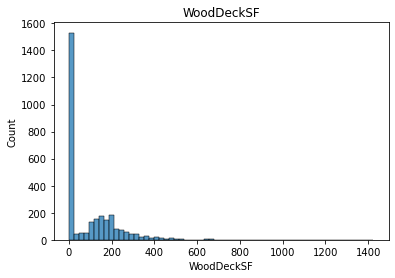

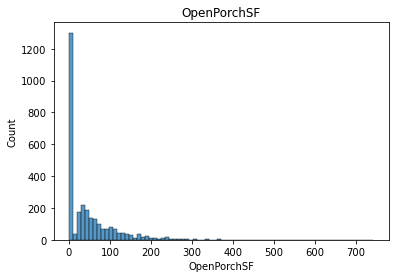

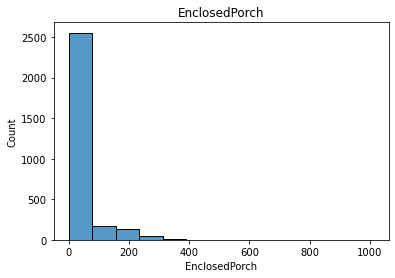

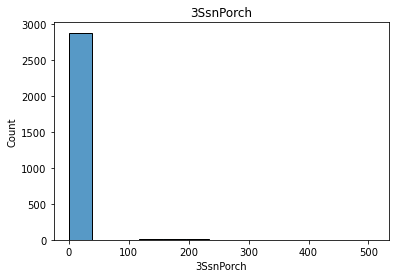

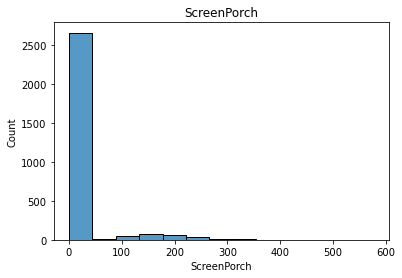

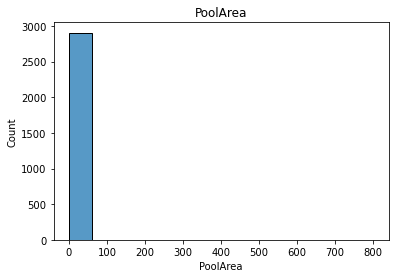

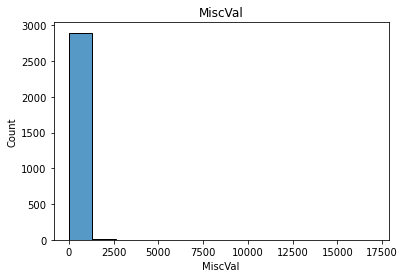

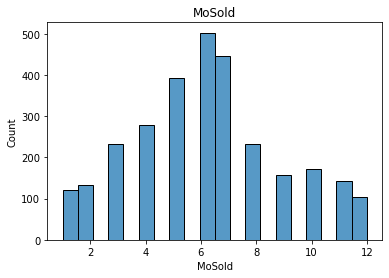

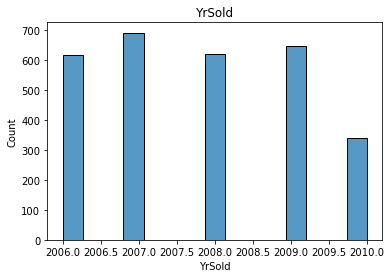

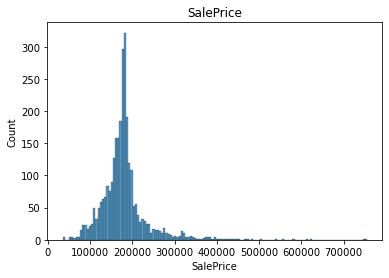

In [13]:
# Seaborn
# numeric kolonların kategorik olup olmadıklarına baktık
for column in all_data[numeric_cols]:
    sns.histplot(data = all_data[column])
    plt.title(column)
    plt.show()

In [15]:
all_data['OverallQual']

0       7
1       6
2       7
3       7
4       8
       ..
1454    4
1455    4
1456    5
1457    5
1458    7
Name: OverallQual, Length: 2919, dtype: int64

In [23]:
# burada sayısal olarak görünen ama kategorik olan kolonları dummy'leştirmeye çalıştık
from sklearn import preprocessing
pd.set_option('display.max_rows', ((all_data.shape[0]) + 1)) 

# numeric ama kategorik olan kolonları ayırdık
numeric_imp_cols = ['OverallQual', 'OverallCond', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                    'Fireplaces', 'GarageCars']

le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()

for column in numeric_imp_cols:
    temp = le.fit_transform(all_data[column])
    cat_num_cols = pd.DataFrame(ohe.fit_transform(temp.reshape(-1, 1)).toarray())
    all_data = pd.concat([all_data, cat_num_cols], axis=1)
    
all_data

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
aa

In [ ]:
# kategorik verileri sayısal değerlere dönüştürdük (dummy)
categorical_cols = all_data.select_dtypes(include=np.object).columns
all_data = pd.get_dummies(all_data, prefix=categorical_cols)

In [ ]:
pd.set_option('display.max_rows', ((all_data.shape[0]) + 1)) 

# aralarındaki korelasyon ilişkisine baktık
cor_matrix = all_data.corr()
cor_matrix['SalePrice'].sort_values(ascending=False)

In [ ]:
all_data

In [ ]:
# indeklerin düzgün olabilmesi için bi kaç ayar yaptk
result = all_data.Id.to_numpy()
result = np.insert(result, 0, 0, axis=0)
result = np.delete(result, len(all_data))

# burada ise yeni indexlerimizi atadık
data = all_data.set_index(keys=result)

In [ ]:
# SalePrice ve Id gibi ihtiyacımız olmayan kolonları sildik
data.drop('SalePrice', axis=1, inplace=True)
data.drop('Id', axis=1, inplace=True)

# x ve y değerlerimizi ayarladık
x = data
y = pd.DataFrame(all_data['SalePrice'])

In [ ]:
x_train= data.iloc[0:1461, :]
x_test = data.iloc[1461:len(data) + 1, :]
y_train = y.iloc[0:1461, :]
y_test = y.iloc[1461:len(data) + 1, :]

In [ ]:
from sklearn.svm import SVR

svr_reg = SVR(C= 1000, gamma= 0.01, kernel= 'sigmoid')
svr_reg.fit(x_train, y_train)

y_pred = svr_reg.predict(x_test)

print('SVR R2 Değeri')
print(r2_score(y_test, y_pred))